In [18]:
import os
import numpy as np
import pandas as pd
import mne
import pickle
import submitit
import matplotlib.pyplot as plt
import seaborn as sns


# prepate the data 

In [ ]:


def average_over_all_channels(pid):
    base_path = f'/mnt/data/AdaptiveControl/IBLrawdata/TF_data'
    pid_path = os.path.join(base_path, pid)
    path_epoch_quality = os.path.join(pid_path, 'epoch_quality_raw.csv')
    
    
    quality_data = pd.read_csv(path_epoch_quality)
    
    freq_bands = {
        'theta': (2, 8),
        'low_gamma': (25, 40)
    }
    
    time_window = (0.1, 1)  # 0-1 seconds after stimulus
    
    results = {band: {condition: [] for condition in ['100%', '25%', '12.5%', '6.25%', '0%']} for band in freq_bands}
    
    files = [f for f in os.listdir(pid_path) if f.startswith('powerLF_raw') and not 'VISpm' in f ]
    
    for file in files:
        print(f'Processing {file}')
        raw = mne.time_frequency.read_tfrs(os.path.join(pid_path, file))
        raw = raw.apply_baseline(baseline=(-0.7, -0.5), mode='percent')
        metadata = raw.metadata.reset_index(drop=True)  
        metadata['rt'] = metadata['response_times'] - metadata['stimOn_times']
        good_rt = metadata[metadata['rt'] < 2.5].index 
        
        channel_name = raw.info['ch_names'][0]
        good_trials = quality_data[(quality_data['channel'] == channel_name) & (quality_data['max_power'] < 500) ]['epoch'].values
        good_trials = [i for i in good_trials if i in good_rt]
        
        # Define conditions based on contrast
        conditions = {
            '100%': np.intersect1d(np.where(((metadata['contrastLeft'] == 1) | (metadata['contrastRight'] == 1)))[0], good_trials),
            '25%': np.intersect1d(np.where(((metadata['contrastLeft'] == 0.25) | (metadata['contrastRight'] == 0.25)))[0], good_trials),
            '12.5%': np.intersect1d(np.where(((metadata['contrastLeft'] == 0.125) | (metadata['contrastRight'] == 0.125)))[0], good_trials),
            '6.25%': np.intersect1d(np.where(((metadata['contrastLeft'] == 0.0625) | (metadata['contrastRight'] == 0.0625)))[0], good_trials),
            '0%': np.intersect1d(np.where(((metadata['contrastLeft'] == 0) | (metadata['contrastRight'] == 0)))[0], good_trials)
        }
        
        # Loop over each frequency band and extract the power
        for band_name, (fmin, fmax) in freq_bands.items():
            band_power = raw.copy().crop(tmin=time_window[0], tmax=time_window[1]).data.squeeze()
            band_power = band_power[:, (raw.freqs >= fmin) & (raw.freqs <= fmax), :]
            # absolout 
            #band_power = np.abs(band_power)
            # Average power across time and trials for each condition
            for condition, trials in conditions.items():
                if len(trials) > 0:
                    avg_power = np.mean(band_power[trials, :, :], axis=(0,1, 2))
                    results[band_name][condition].append({
                        'channel': channel_name,
                        'avg_power': avg_power
                    })
    
    # Save results
    save_path = os.path.join(base_path, pid,  f'contrast_Fbands.pkl')
    with open(save_path, 'wb') as f:
        pickle.dump(results, f)
    
    print(f'Results saved for PID: {pid}')

path = '/crnldata/cophy/TeamProjects/mohammad/ibl-oscillations/_analyses/_IBLworkflows/preprocessing/clean_data.csv'
df = pd.read_csv(path)
pids = df['pid'].values


for i, pid in enumerate(pids): 
    
    # if i> 0:
    #     break   
    print(pid)       
    executor = submitit.AutoExecutor(folder="logs")
    # pass parameter to the executor
    executor.update_parameters(mem_gb=8, timeout_min=600, slurm_partition="CPU", cpus_per_task=1)
    # execute the job (note the .map_array command that different from the .submit command used above)
    jobs = executor.submit(average_over_all_channels, pid)

In [1]:
import os
import pickle
import pandas as pd

# Base path where the data for each PID is stored
base_path = '/mnt/data/AdaptiveControl/IBLrawdata/TF_data'

# Load the list of PIDs from the provided CSV file
pids_path = '/crnldata/cophy/TeamProjects/mohammad/ibl-oscillations/_analyses/_IBLworkflows/preprocessing/clean_data.csv'
pids_df = pd.read_csv(pids_path)
pids = pids_df['pid'].values

# Initialize an empty list to store aggregated data
all_data = []

# Loop through each PID and load the corresponding results
for pid in pids:
    pid_path = os.path.join(base_path, pid, 'contrast_Fbands.pkl')
    if os.path.exists(pid_path):
        with open(pid_path, 'rb') as f:
            results = pickle.load(f)
        
        # Convert the results into a DataFrame and add the PID as a column
        for band, conditions in results.items():
            for condition, channels in conditions.items():
                for channel_info in channels:
                    all_data.append([pid, band, condition, channel_info['avg_power'], channel_info['channel']])

# Convert the aggregated data into a DataFrame
df_aggregated = pd.DataFrame(all_data, columns=['pid', 'band', 'contrast', 'avg_power', 'channel'])

df_aggregated.to_csv('fband_contrast.csv', index=False)


In [3]:
df_aggregated = pd.read_csv('fband_contrast.csv')
df_aggregated_avg = df_aggregated.groupby(['pid', 'band', 'contrast']).agg({'avg_power': 'mean'}).reset_index()
df_aggregated_avg_theta = df_aggregated_avg[df_aggregated_avg['band'] == 'theta']
df_aggregated_avg_gamma = df_aggregated_avg[df_aggregated_avg['band'] == 'low_gamma']


# first visualization of data 

/tmp/ipykernel_290877/2225731456.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='contrast', y='avg_power', data=data, palette="Set2")


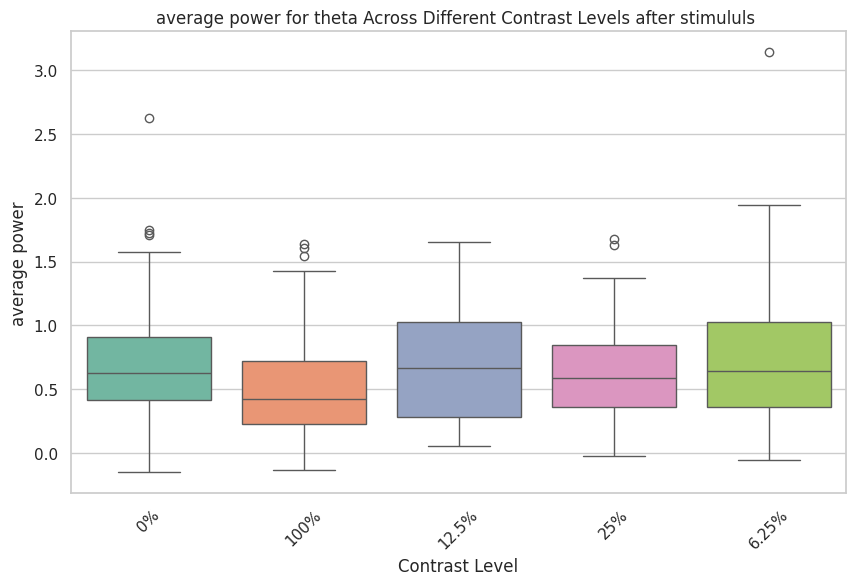

/tmp/ipykernel_290877/2225731456.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='contrast', y='avg_power', data=data, palette="Set2")


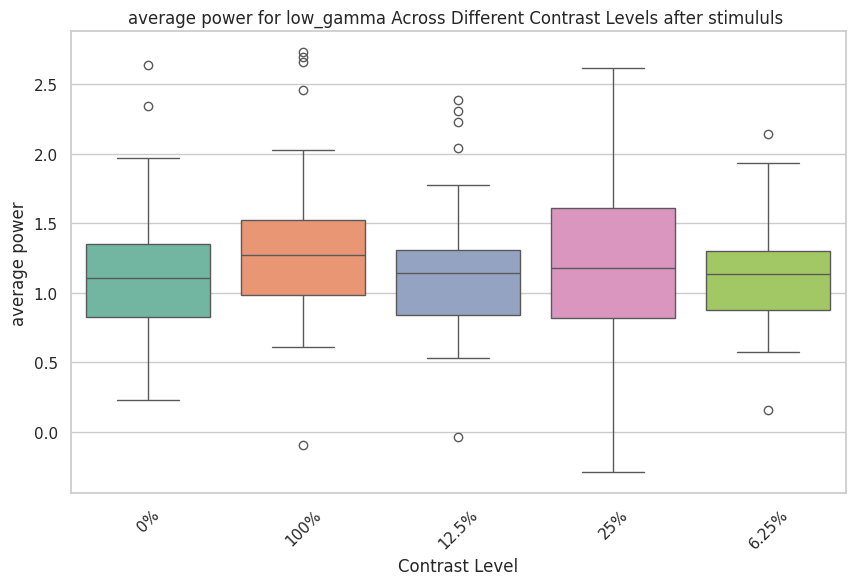

In [5]:
# Set the style for the plots
sns.set(style="whitegrid")
bands = ['theta', 'low_gamma']
for band in bands:
    data = df_aggregated_avg[df_aggregated_avg['band'] == band]
    # Create a boxplot to show the distribution of ITC mean across different contrast levels
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='contrast', y='avg_power', data=data, palette="Set2")

    plt.title(f'average power for {band} Across Different Contrast Levels after stimululs ')
    plt.xlabel('Contrast Level')
    plt.ylabel('average power')
    plt.xticks(rotation=45)
    plt.show()

# shapiro test for normality and repeated measures anova

Band: theta
contrast        0%      100%     12.5%       25%     6.25%
0         0.898667  0.897009  0.948507  0.956437  0.867483
1         0.001749  0.001566  0.067378  0.126378  0.000246                  Anova
         F Value Num DF  Den DF  Pr > F
---------------------------------------
contrast  6.4525 4.0000 156.0000 0.0001



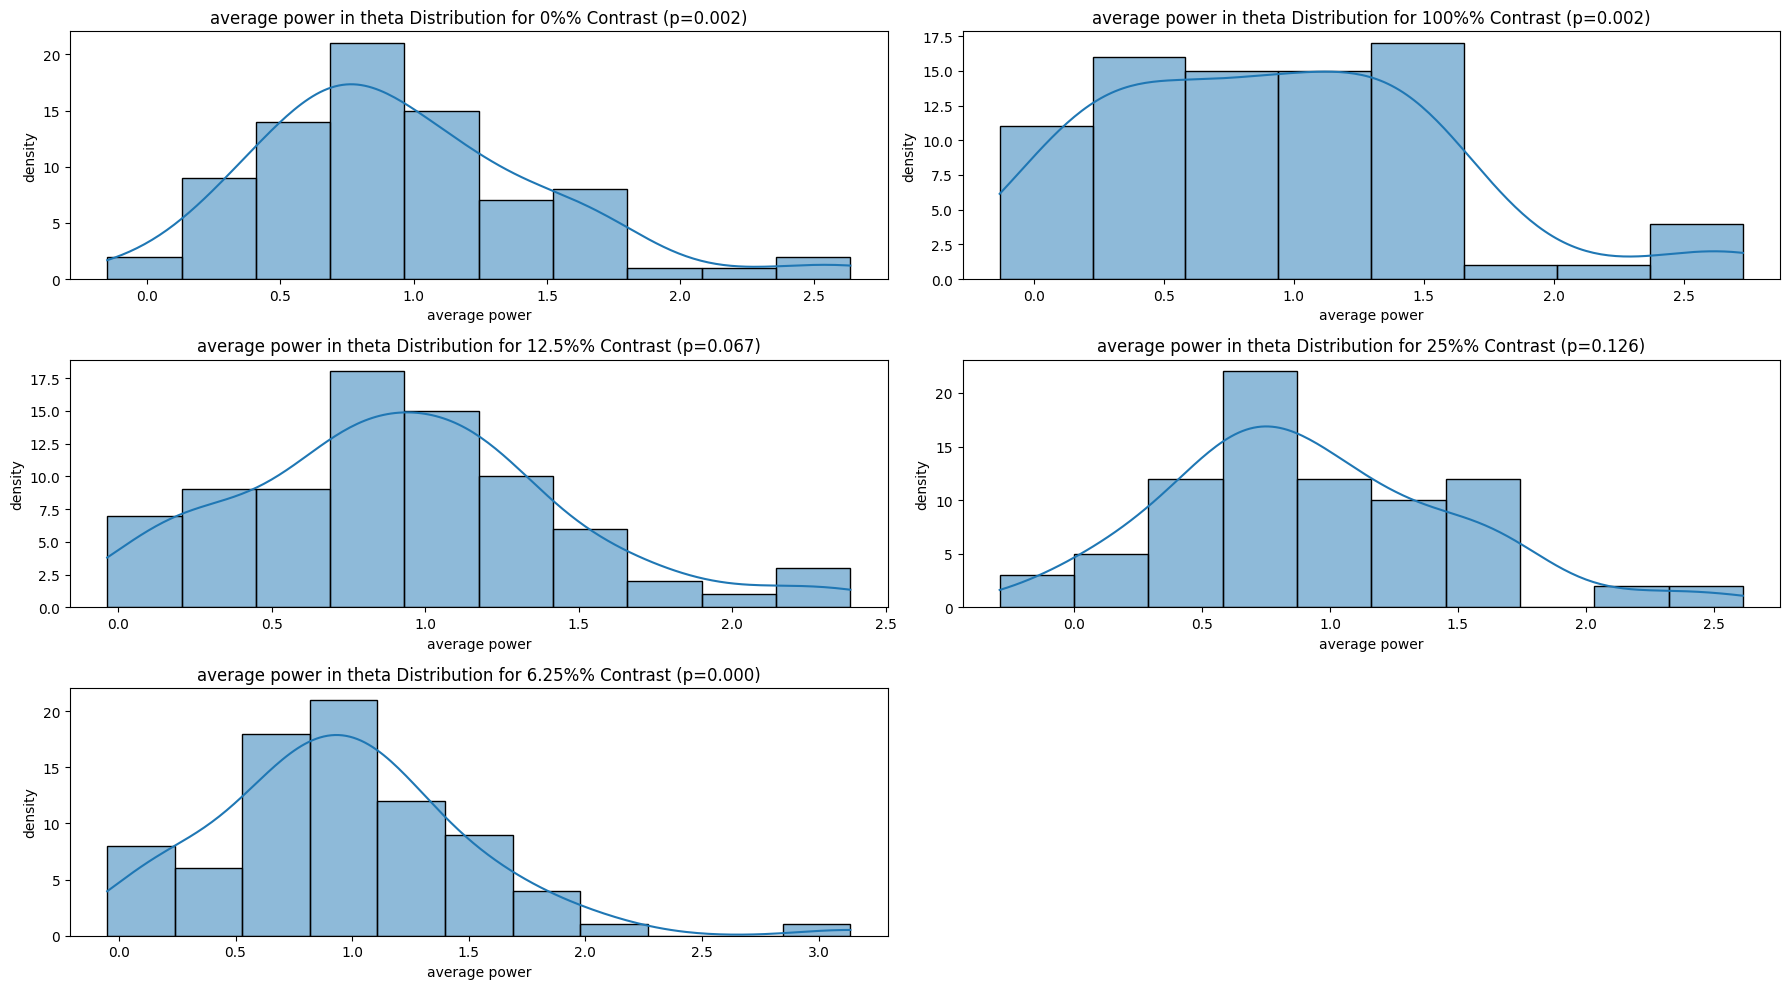

Band: low_gamma
contrast        0%      100%     12.5%       25%     6.25%
0         0.927257  0.911942  0.932385  0.943514  0.968237
1         0.013119  0.004336  0.019281  0.045478  0.316007                  Anova
         F Value Num DF  Den DF  Pr > F
---------------------------------------
contrast  5.0309 4.0000 156.0000 0.0008



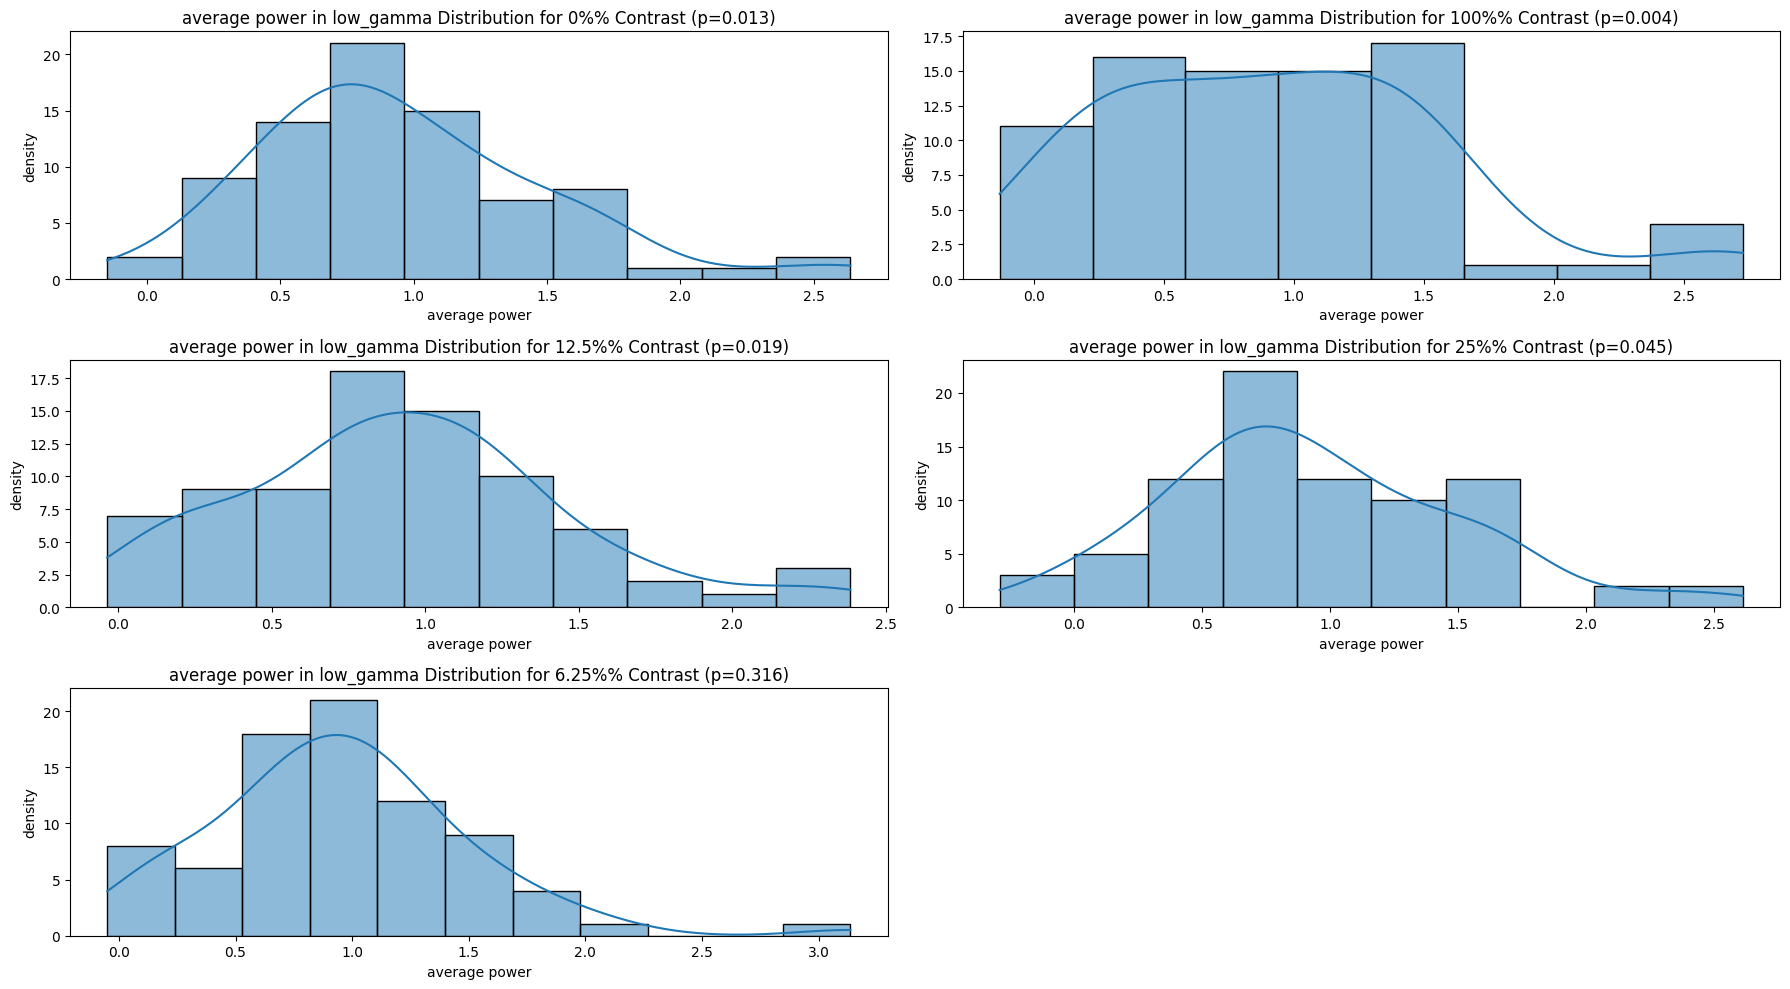

In [25]:
from scipy.stats import shapiro
from statsmodels.stats.anova import AnovaRM
import numpy as np

bands = ['theta', 'low_gamma']
for band in bands:
    data = df_aggregated_avg[df_aggregated_avg['band'] == band]
    # First, we'll pivot the data to get the ITC values for each contrast level per subject
    data_pivot = data.pivot(index= 'pid' , columns='contrast', values='avg_power')

    # Normality assumption: We'll use Shapiro-Wilk test for each contrast condition
    normality_results = data_pivot.apply(shapiro)

    # Conduct repeated measures ANOVA (without sphericity correction for initial check)
    anova_model = AnovaRM(data, 'avg_power', 'pid', within=['contrast'])
    anova_results = anova_model.fit()
    print(f'Band: {band}')
    # Outputting the results
    print(normality_results, anova_results.summary())
    plt.figure(figsize=(18, 10))
    # Plot each contrast condition
    for i, contrast in enumerate(sorted(df_aggregated_avg['contrast'].unique()), 1):
        plt.subplot(3, 2, i)
        pvalue = normality_results[contrast][1]
        sns.histplot(df_aggregated_avg[df_aggregated_avg['contrast'] == contrast]['avg_power'], kde=True)
        plt.title(f'average power in {band} Distribution for {contrast}% Contrast (p={pvalue:.3f})')
        plt.xlabel('average power')
        plt.ylabel('density')

    plt.tight_layout()
    plt.show()



# Friedman test statistic

In [2]:


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.anova import AnovaRM



# Importing the necessary statistical test
from scipy.stats import friedmanchisquare

df_aggregated = pd.read_csv('fband_contrast.csv')
df_aggregated_avg = df_aggregated.groupby(['pid', 'band', 'contrast']).agg({'avg_power': 'mean'}).reset_index()

bands = ['theta', 'low_gamma']
for band in bands:
    data = df_aggregated_avg[df_aggregated_avg['band'] == band]
    # First, we'll pivot the data to get the ITC values for each contrast level per subject
    data_pivot = data.pivot(index= 'pid' , columns='contrast', values='avg_power')
    statistic, p_value = friedmanchisquare(*data_pivot.T.values)
    print(f'Band: {band}')
    print(f'Friedman test statistic: {statistic}, p-value: {p_value}')

    



Band: theta
Friedman test statistic: 20.539999999999964, p-value: 0.00039058862103991804
Band: low_gamma
Friedman test statistic: 18.879999999999995, p-value: 0.0008297754652678139


# posthoc_nemenyi_friedman
to test the differences between the conditions, I used the Nemenyi post-hoc test

             0%      100%     12.5%       25%     6.25%
0%     1.000000  0.001268  0.900000  0.351727  0.900000
100%   0.001268  1.000000  0.012728  0.275862  0.001673
12.5%  0.900000  0.012728  1.000000  0.723137  0.900000
25%    0.351727  0.275862  0.723137  1.000000  0.393897
6.25%  0.900000  0.001673  0.900000  0.393897  1.000000


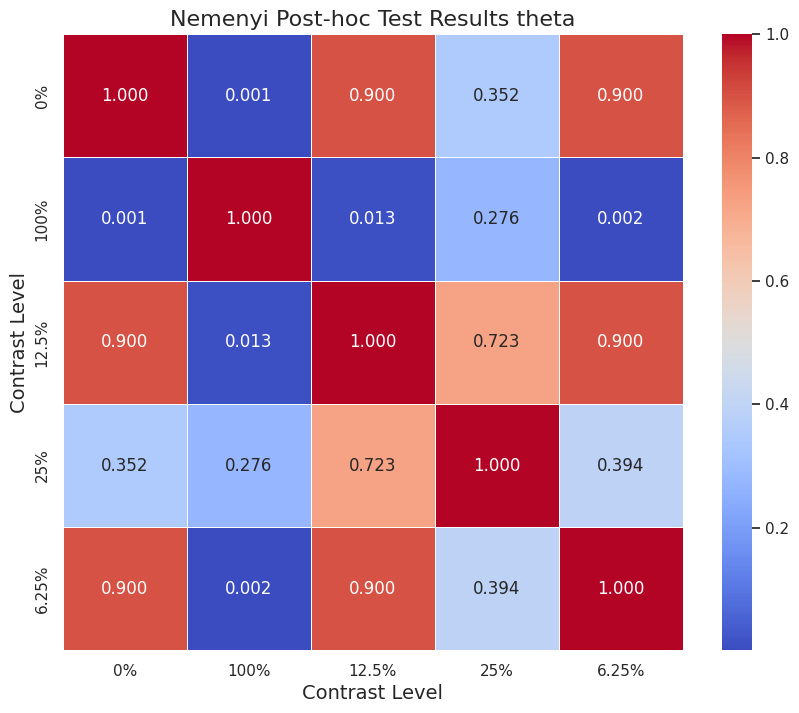

             0%      100%     12.5%       25%     6.25%
0%     1.000000  0.003729  0.900000  0.900000  0.900000
100%   0.003729  1.000000  0.006194  0.037722  0.002198
12.5%  0.900000  0.006194  1.000000  0.900000  0.900000
25%    0.900000  0.037722  0.900000  1.000000  0.900000
6.25%  0.900000  0.002198  0.900000  0.900000  1.000000


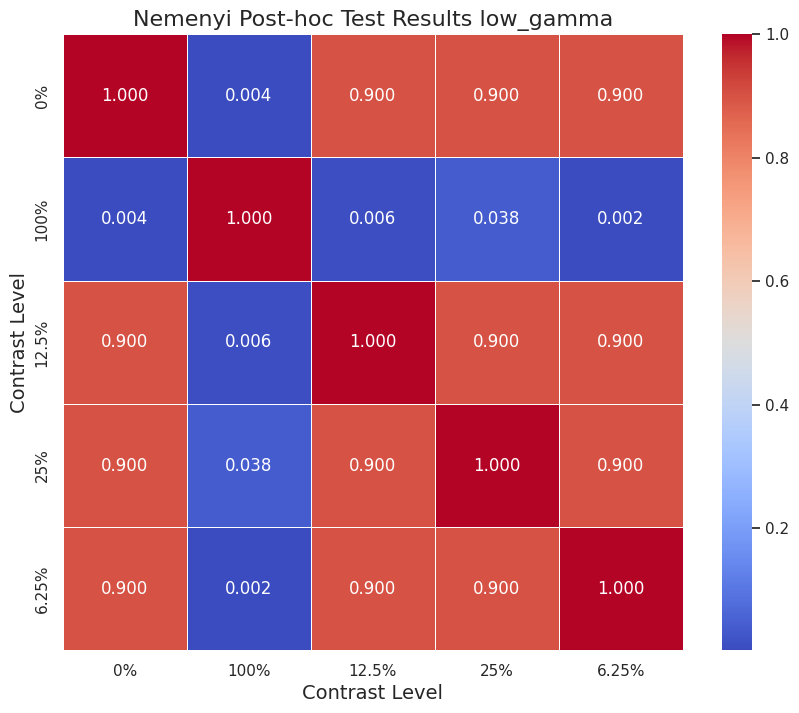

In [7]:
from scikit_posthocs import posthoc_nemenyi_friedman
bands = ['theta', 'low_gamma']
for band in bands:
    data = df_aggregated_avg[df_aggregated_avg['band'] == band]
    # First, we'll pivot the data to get the ITC values for each contrast level per subject
    data_pivot = data.pivot(index= 'pid' , columns='contrast', values='avg_power')

    # Perform the Nemenyi post-hoc test
    nemenyi_results = posthoc_nemenyi_friedman(data_pivot)

    # Display the results
    print(nemenyi_results)

    # Create a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(nemenyi_results, annot=True, cmap='coolwarm', fmt=".3f", linewidths=.5)

    # Add titles and labels
    plt.title(f"Nemenyi Post-hoc Test Results {band}", fontsize=16)
    plt.xlabel('Contrast Level', fontsize=14)
    plt.ylabel('Contrast Level', fontsize=14)

    plt.show()

# spearmanr
to test the correlation between the contrast and the average power, I used the Spearman correlation

/tmp/ipykernel_290877/1059335410.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['contrast'] = data['contrast'].str.rstrip('%').astype('float')


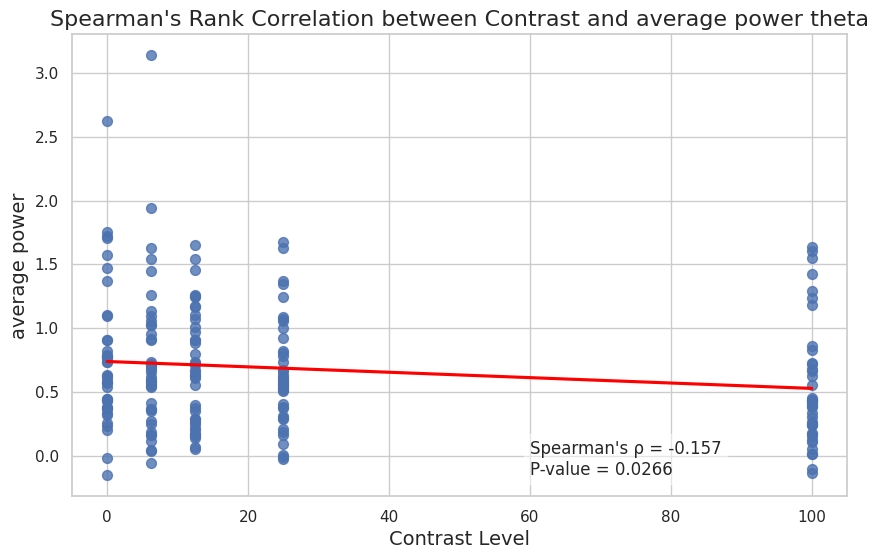

/tmp/ipykernel_290877/1059335410.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['contrast'] = data['contrast'].str.rstrip('%').astype('float')


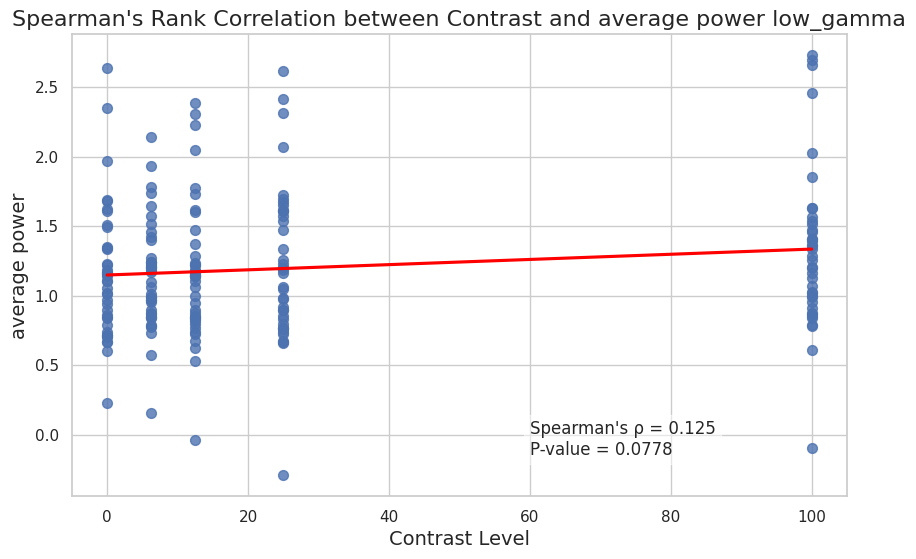

In [14]:
from scipy.stats import spearmanr

bands = ['theta', 'low_gamma']
for band in bands:
    data = df_aggregated_avg[df_aggregated_avg['band'] == band]# Convert columns to numeric, coercing errors to NaN
    data['contrast'] = data['contrast'].str.rstrip('%').astype('float')
    


    # Perform Spearman's rank correlation between contrast and average power
    # Flattening the data to compare contrast and average power directly
    contrast = data['contrast']
    avg_power = data['avg_power']

    spearman_corr, spearman_p_value = spearmanr(contrast, avg_power)

    # print(spearman_corr, spearman_p_value)
    # Create a scatter plot with a regression line to illustrate Spearman's rank correlation

    plt.figure(figsize=(10, 6))
    sns.regplot(x=contrast, y=avg_power, scatter_kws={'s':50}, ci=None, line_kws={'color':'red'}, marker='o')

    # Add titles and labels
    plt.title(f"Spearman's Rank Correlation between Contrast and average power {band}", fontsize=16)
    plt.xlabel('Contrast Level', fontsize=14)
    plt.ylabel('average power', fontsize=14)
    plt.grid(True)

    # Display the correlation coefficient on the plot
    plt.text(60, min(itc_mean) + 0.005, f"Spearman's ρ = {spearman_corr:.3f}\nP-value = {spearman_p_value:.3g}", 
            fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

    plt.show()

# seperating layers and first visualization of data

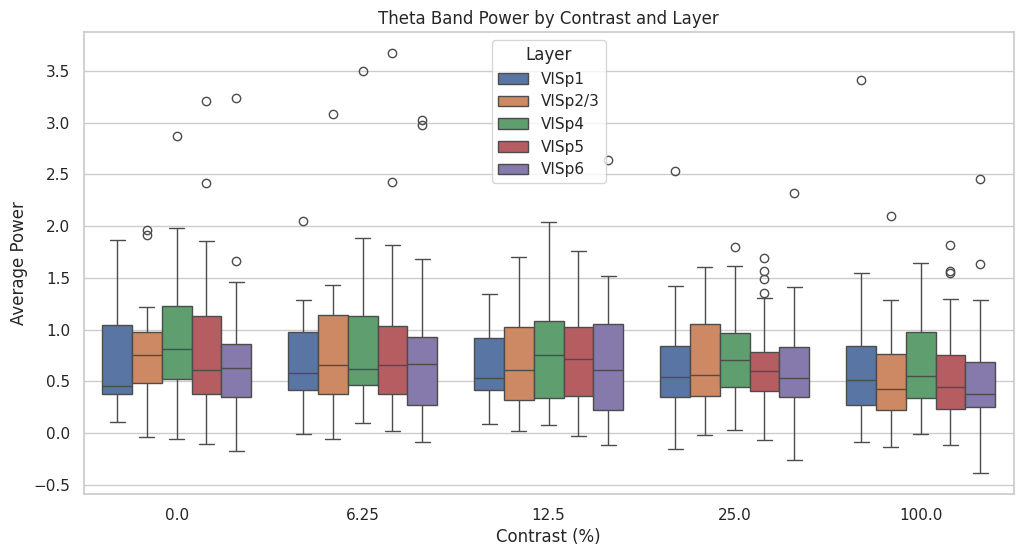

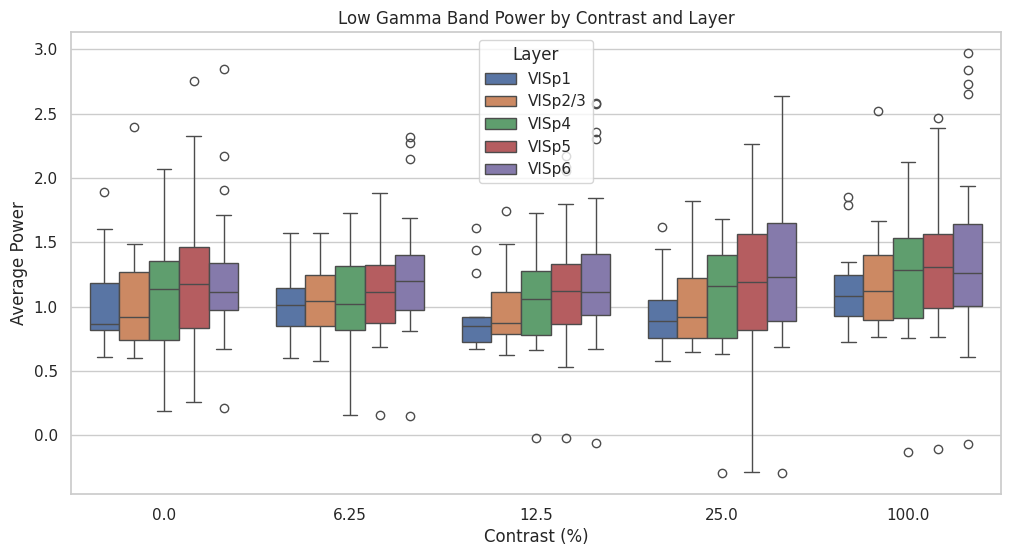

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = 'fband_contrast.csv'
data = pd.read_csv(file_path)

# Extract the layer information from the channel column and create a new column for it
data['layer'] = data['channel'].str.extract(r'(VISp\d+\/?\d*)')

# Remove the percentage sign from the contrast column and convert it to a float
data['contrast'] = data['contrast'].str.replace('%', '').astype(float)

# Group the data by pid, band, contrast, and layer, then calculate the mean avg_power
grouped_data = data.groupby(['pid', 'band', 'contrast', 'layer'])['avg_power'].mean().reset_index()

# Create a boxplot for theta band
plt.figure(figsize=(12, 6))
sns.boxplot(x='contrast', y='avg_power', hue='layer', data=grouped_data[grouped_data['band'] == 'theta'])
plt.title('Theta Band Power by Contrast and Layer')
plt.xlabel('Contrast (%)')
plt.ylabel('Average Power')
plt.legend(title='Layer')
plt.show()

# Create a boxplot for low_gamma band
plt.figure(figsize=(12, 6))
sns.boxplot(x='contrast', y='avg_power', hue='layer', data=grouped_data[grouped_data['band'] == 'low_gamma'])
plt.title('Low Gamma Band Power by Contrast and Layer')
plt.xlabel('Contrast (%)')
plt.ylabel('Average Power')
plt.legend(title='Layer')
plt.show()

# normality test after removing outliers

In [19]:
from scipy.stats import shapiro
# Function to identify and remove outliers using 95th percentile method
def remove_outliers_percentile(df, column):
    lower_bound = df[column].quantile(0.025)
    upper_bound = df[column].quantile(0.975)
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Initialize a dictionary to store Shapiro test results and count of removed outliers
shapiro_results = []
total_outliers_removed = 0

# Iterate through each layer and condition (band + contrast) to remove outliers and test normality
for layer in grouped_data['layer'].unique():
    for band in grouped_data['band'].unique():
        for contrast in grouped_data['contrast'].unique():
            subset = grouped_data[(grouped_data['layer'] == layer) & 
                                  (grouped_data['band'] == band) & 
                                  (grouped_data['contrast'] == contrast)]
            
            # Count the original number of samples
            original_count = len(subset)
            
            # Remove outliers using 95th percentile
            subset_no_outliers = remove_outliers_percentile(subset, 'avg_power')
            
            # Count the number of outliers removed
            outliers_removed = original_count - len(subset_no_outliers)
            total_outliers_removed += outliers_removed
            
            # Perform Shapiro-Wilk test for normality
            if len(subset_no_outliers) > 3:  # Shapiro test requires at least 3 samples
                stat, p_value = shapiro(subset_no_outliers['avg_power'])
                shapiro_results.append({
                    'layer': layer,
                    'band': band,
                    'contrast': contrast,
                    'p_value': p_value,
                    'normal': p_value > 0.05,
                    'outliers_removed': outliers_removed
                })

# Convert results to a DataFrame
shapiro_results_df = pd.DataFrame(shapiro_results)

import pandas as pd
from IPython.display import display

# Assuming shapiro_results_df is already defined
display(shapiro_results_df)

,layer,band,contrast,p_value,normal,outliers_removed
0,VISp1,low_gamma,0.00,0.087044,True,2
1,VISp1,low_gamma,6.25,0.995160,True,2
2,VISp1,low_gamma,12.50,0.004271,False,2
3,VISp1,low_gamma,25.00,0.460150,True,2
4,VISp1,low_gamma,100.00,0.055696,True,2
5,VISp1,theta,0.00,0.009221,False,2
6,VISp1,theta,6.25,0.215806,True,2
7,VISp1,theta,12.50,0.172666,True,2
8,VISp1,theta,25.00,0.086049,True,2
9,VISp1,theta,100.00,0.397990,True,2


# remove outliers

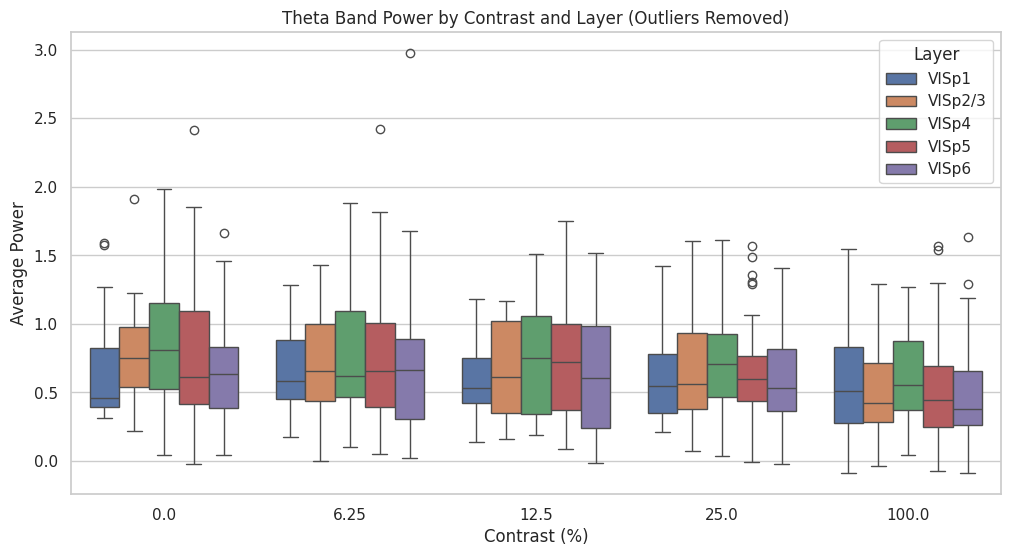

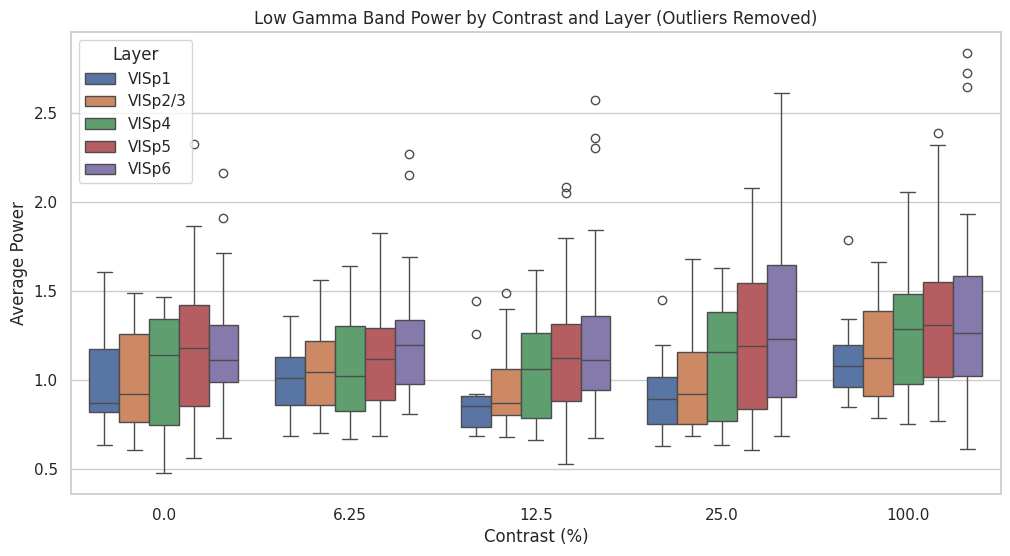

In [20]:
# Remove outliers from the dataset using 95th percentile method
filtered_data = pd.DataFrame()

for layer in grouped_data['layer'].unique():
    for band in grouped_data['band'].unique():
        for contrast in grouped_data['contrast'].unique():
            subset = grouped_data[(grouped_data['layer'] == layer) & 
                                  (grouped_data['band'] == band) & 
                                  (grouped_data['contrast'] == contrast)]
            
            # Remove outliers using 95th percentile
            subset_no_outliers = remove_outliers_percentile(subset, 'avg_power')
            
            # Append the filtered data
            filtered_data = pd.concat([filtered_data, subset_no_outliers])

# Create a boxplot for theta band after removing outliers
plt.figure(figsize=(12, 6))
sns.boxplot(x='contrast', y='avg_power', hue='layer', data=filtered_data[filtered_data['band'] == 'theta'])
plt.title('Theta Band Power by Contrast and Layer (Outliers Removed)')
plt.xlabel('Contrast (%)')
plt.ylabel('Average Power')
plt.legend(title='Layer')
plt.show()

# Create a boxplot for low_gamma band after removing outliers
plt.figure(figsize=(12, 6))
sns.boxplot(x='contrast', y='avg_power', hue='layer', data=filtered_data[filtered_data['band'] == 'low_gamma'])
plt.title('Low Gamma Band Power by Contrast and Layer (Outliers Removed)')
plt.xlabel('Contrast (%)')
plt.ylabel('Average Power')
plt.legend(title='Layer')
plt.show()


# friedmanchisquare

In [21]:
from scipy.stats import friedmanchisquare

# Prepare a dictionary to store Friedman test results
friedman_results = []

# Perform Friedman test for each band and layer to see if contrast affects the average power
for band in filtered_data['band'].unique():
    for layer in filtered_data['layer'].unique():
        # Extract data for this band and layer across different contrasts
        subset = filtered_data[(filtered_data['band'] == band) & (filtered_data['layer'] == layer)]
        
        # Pivot the data to get contrasts as columns for each pid
        pivoted_data = subset.pivot(index='pid', columns='contrast', values='avg_power').dropna()
        
        # Perform Friedman test
        if pivoted_data.shape[0] > 2:  # At least 3 subjects are needed
            stat, p_value = friedmanchisquare(*[pivoted_data[col] for col in pivoted_data.columns])
            friedman_results.append({
                'band': band,
                'layer': layer,
                'p_value': p_value,
                'significant': p_value < 0.05
            })
            
display(pd.DataFrame(friedman_results))

,band,layer,p_value,significant
0,low_gamma,VISp1,0.140771,False
1,low_gamma,VISp2/3,0.019448,True
2,low_gamma,VISp4,0.029806,True
3,low_gamma,VISp5,0.018902,True
4,low_gamma,VISp6,0.145106,False
5,theta,VISp1,0.537948,False
6,theta,VISp2/3,0.063051,False
7,theta,VISp4,0.114384,False
8,theta,VISp5,0.035552,True
9,theta,VISp6,0.057730,False


# all subject and channels seperated plot (just in case)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns



# Get the unique PIDs (subjects) and loop through each
pids = df_aggregated['pid'].unique()
for pid in pids:
    plt.figure(figsize=(10, 6))
    # Filter data for the current PID and theta band
    theta_data = df_aggregated[(df_aggregated['band'] == 'theta') & (df_aggregated['pid'] == pid)]
    
    # Plot a line for each channel
    sns.lineplot(x='contrast', y='avg_power', hue='channel', data=theta_data, marker='o', palette='tab10')
    

    # Add titles and labels
    plt.title(f'Theta Band Power Across Contrast Levels for PID: {pid}')
    plt.xlabel('Contrast Level')
    plt.ylabel('Average Power')
    
    # Show the plot
    plt.legend(title='Channel', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


# plotting the results for two pid , first one has significant difference between the conditions and the second one has no significant difference

In [ ]:
# Set up the figure and axes for individual plotting
import matplotlib.pyplot as plt
import seaborn as sns
# Plot for theta band
plt.figure(figsize=(7, 6))
sns.boxplot(x='contrast', y='avg_power', 
            data=df_aggregated_avg[df_aggregated_avg['band'] == 'theta'],
            order=['0%', '6.25%', '12.5%', '25%', '100%'])
plt.title('Theta Band Power Across Contrast Levels')
plt.xlabel('Contrast Level')
plt.ylabel('Average Power')
# plt.ylim(0, 1)  # Consistent y-limits for easier comparison
plt.tight_layout()
plt.show()

# Plot for low gamma band
plt.figure(figsize=(7, 6))
sns.boxplot(x='contrast', y='avg_power', 
            data=df_aggregated_avg[df_aggregated_avg['band'] == 'low_gamma'],
            order=['0%', '6.25%', '12.5%', '25%', '100%'])
plt.title('Low Gamma Band Power Across Contrast Levels')
plt.xlabel('Contrast Level')
plt.ylabel('Average Power')
# plt.ylim(0, 1)  # Consistent y-limits for easier comparison
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter the data for the theta band
theta_data = df_aggregated_avg[df_aggregated_avg['band'] == 'theta']

# Set the order of the contrast levels
contrast_order = ['0%', '6.25%', '12.5%', '25%', '100%']

# Create a line plot for each subject
plt.figure(figsize=(10, 6))
sns.lineplot(x='contrast', y='avg_power',  data=theta_data, marker='o')

# Set the x-axis to the desired order
plt.xticks(ticks=range(len(contrast_order)), labels=contrast_order)

# Add titles and labels
plt.title('Average Theta Band Power Across Contrast Levels for Each Subject')
plt.xlabel('Contrast Level')
plt.ylabel('Average Power')

# Show the plot
# plt.legend(title='Subject ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
pid = '4b93a168-0f3b-4124-88fa-a57046ca70e1'
base_path = f'/mnt/data/AdaptiveControl/IBLrawdata/TF_data'
pid_path = os.path.join(base_path, pid)
path_epoch_quality = os.path.join(pid_path, 'epoch_quality_raw.csv')


quality_data = pd.read_csv(path_epoch_quality)

freq_bands = {
    'theta': (2, 8),
    'low_gamma': (25, 40)
}

time_window = (0.1, 1)  # 0-1 seconds after stimulus

results = {band: {condition: [] for condition in ['100%', '25%', '12.5%', '6.25%', '0%']} for band in freq_bands}

files = [f for f in os.listdir(pid_path) if f.startswith('powerLF_raw') and not 'VISpm' in f ]

for i, file in enumerate(files):
    # if i > 10:
    #     break
    print(f'Processing {file}')
    raw = mne.time_frequency.read_tfrs(os.path.join(pid_path, file))
    raw = raw.apply_baseline(baseline=(-0.7, -0.5), mode='percent')
    metadata = raw.metadata.reset_index(drop=True)  
    metadata['rt'] = metadata['response_times'] - metadata['stimOn_times']
    good_rt = metadata[metadata['rt'] < 2.5].index 
    
    channel_name = raw.info['ch_names'][0]
    good_trials = quality_data[(quality_data['channel'] == channel_name) & (quality_data['max_power'] < 500) ]['epoch'].values
    good_trials = [i for i in good_trials if i in good_rt]
    
    # Define conditions based on contrast
    conditions = {
        '100%': np.intersect1d(np.where(((metadata['contrastLeft'] == 1) | (metadata['contrastRight'] == 1)))[0], good_trials),
        '25%': np.intersect1d(np.where(((metadata['contrastLeft'] == 0.25) | (metadata['contrastRight'] == 0.25)))[0], good_trials),
        '12.5%': np.intersect1d(np.where(((metadata['contrastLeft'] == 0.125) | (metadata['contrastRight'] == 0.125)))[0], good_trials),
        '6.25%': np.intersect1d(np.where(((metadata['contrastLeft'] == 0.0625) | (metadata['contrastRight'] == 0.0625)))[0], good_trials),
        '0%': np.intersect1d(np.where(((metadata['contrastLeft'] == 0) | (metadata['contrastRight'] == 0)))[0], good_trials)
    }
    
    # Loop over each frequency band and extract the power
    for band_name, (fmin, fmax) in freq_bands.items():
        band_power = raw.copy().crop(tmin=time_window[0], tmax=time_window[1]).data.squeeze()
        band_power = band_power[:, (raw.freqs >= fmin) & (raw.freqs <= fmax), :]
        # absolout 
        #band_power = np.abs(band_power)
        # Average power across time and trials for each condition
        for condition, trials in conditions.items():
            if len(trials) > 0:
                avg_power = np.mean(band_power[trials, :, :], axis=(0,1, 2))
                results[band_name][condition].append({
                    'channel': channel_name,
                    'avg_power': avg_power
                })


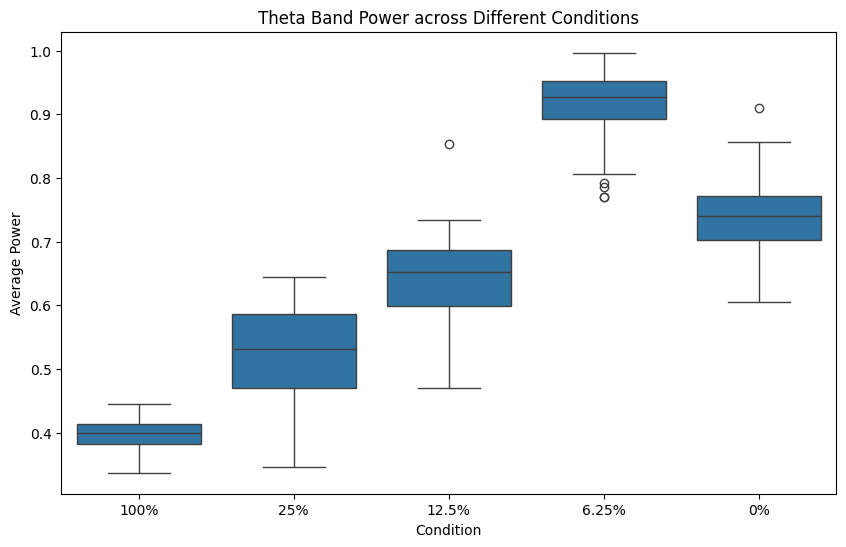

In [40]:

import matplotlib.pyplot as plt
import seaborn as sns
# Collect data for plotting
theta_data = []
for condition, values in results['theta'].items():
    for entry in values:
        theta_data.append({'condition': condition, 'avg_power': entry['avg_power']})

# Create DataFrame for plotting
df_theta = pd.DataFrame(theta_data)

# Plotting
plt.figure(figsize=(10, 6))
sns.boxplot(x='condition', y='avg_power', data=df_theta)
plt.title('Theta Band Power across Different Conditions')
plt.xlabel('Condition')
plt.ylabel('Average Power')
plt.show()

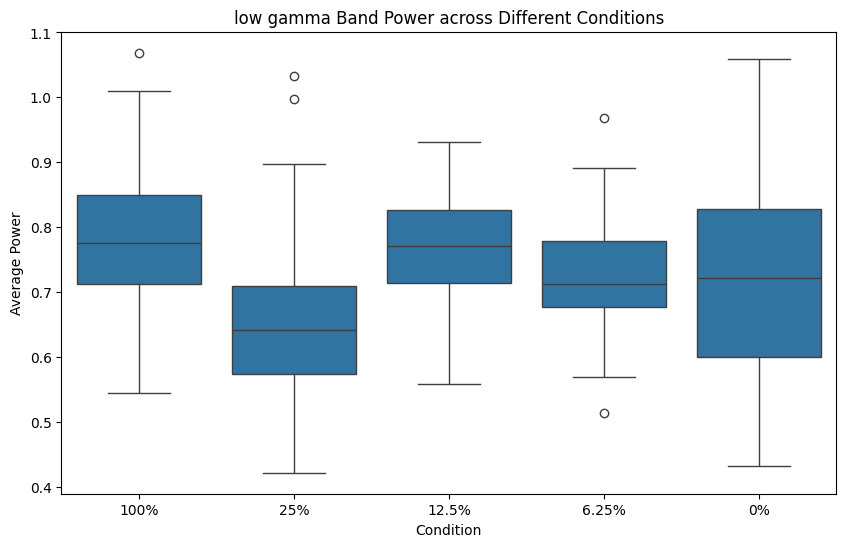

In [2]:

import matplotlib.pyplot as plt
import seaborn as sns
# Collect data for plotting
theta_data = []
for condition, values in results['low_gamma'].items():
    for entry in values:
        theta_data.append({'condition': condition, 'avg_power': entry['avg_power']})

# Create DataFrame for plotting
df_theta = pd.DataFrame(theta_data)

# Plotting
plt.figure(figsize=(10, 6))
sns.boxplot(x='condition', y='avg_power', data=df_theta)
plt.title('low gamma Band Power across Different Conditions')
plt.xlabel('Condition')
plt.ylabel('Average Power')
plt.show()

In [ ]:

pid = '176b4fe3-f570-4d9f-9e25-a5d218f75c8b'

base_path = f'/mnt/data/AdaptiveControl/IBLrawdata/TF_data'
pid_path = os.path.join(base_path, pid)
path_epoch_quality = os.path.join(pid_path, 'epoch_quality_raw.csv')


quality_data = pd.read_csv(path_epoch_quality)

freq_bands = {
    'theta': (2, 8),
    'low_gamma': (25, 40)
}

time_window = (0.1, 1)  # 0-1 seconds after stimulus

results = {band: {condition: [] for condition in ['100%', '25%', '12.5%', '6.25%', '0%']} for band in freq_bands}

files = [f for f in os.listdir(pid_path) if f.startswith('powerLF_raw') and not 'VISpm' in f ]

for i, file in enumerate(files):
    if i > 10:
        break
    print(f'Processing {file}')
    raw = mne.time_frequency.read_tfrs(os.path.join(pid_path, file))
    raw = raw.apply_baseline(baseline=(-0.7, -0.5), mode='percent')
    metadata = raw.metadata.reset_index(drop=True)  
    metadata['rt'] = metadata['response_times'] - metadata['stimOn_times']
    good_rt = metadata[metadata['rt'] < 2.5].index 
    
    channel_name = raw.info['ch_names'][0]
    good_trials = quality_data[(quality_data['channel'] == channel_name) & (quality_data['max_power'] < 500) ]['epoch'].values
    good_trials = [i for i in good_trials if i in good_rt]
    
    # Define conditions based on contrast
    conditions = {
        '100%': np.intersect1d(np.where(((metadata['contrastLeft'] == 1) | (metadata['contrastRight'] == 1)))[0], good_trials),
        '25%': np.intersect1d(np.where(((metadata['contrastLeft'] == 0.25) | (metadata['contrastRight'] == 0.25)))[0], good_trials),
        '12.5%': np.intersect1d(np.where(((metadata['contrastLeft'] == 0.125) | (metadata['contrastRight'] == 0.125)))[0], good_trials),
        '6.25%': np.intersect1d(np.where(((metadata['contrastLeft'] == 0.0625) | (metadata['contrastRight'] == 0.0625)))[0], good_trials),
        '0%': np.intersect1d(np.where(((metadata['contrastLeft'] == 0) | (metadata['contrastRight'] == 0)))[0], good_trials)
    }
    
    # Loop over each frequency band and extract the power
    for band_name, (fmin, fmax) in freq_bands.items():
        band_power = raw.copy().crop(tmin=time_window[0], tmax=time_window[1]).data.squeeze()
        band_power = band_power[:, (raw.freqs >= fmin) & (raw.freqs <= fmax), :]
        # absolout 
        #band_power = np.abs(band_power)
        # Average power across time and trials for each condition
        for condition, trials in conditions.items():
            if len(trials) > 0:
                avg_power = np.mean(band_power[trials, :, :], axis=(0,1, 2))
                results[band_name][condition].append({
                    'channel': channel_name,
                    'avg_power': avg_power
                })

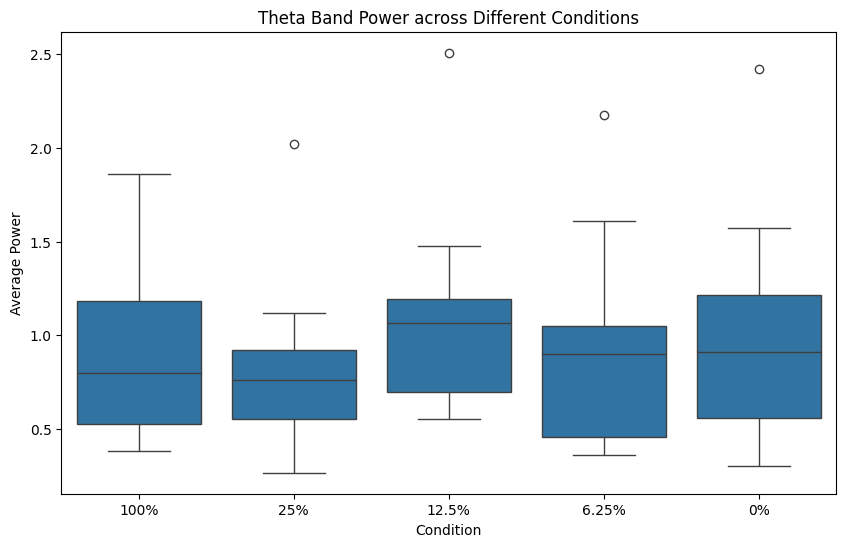

In [45]:

import matplotlib.pyplot as plt
import seaborn as sns
# Collect data for plotting
theta_data = []
for condition, values in results['theta'].items():
    for entry in values:
        theta_data.append({'condition': condition, 'avg_power': entry['avg_power']})

# Create DataFrame for plotting
df_theta = pd.DataFrame(theta_data)

# Plotting
plt.figure(figsize=(10, 6))
sns.boxplot(x='condition', y='avg_power', data=df_theta)
plt.xlabel('Condition')
plt.ylabel('Average Power')
plt.show()